# Compilation
Compile destination C file.  
Input: name of file without extension format
Output: finished / failed

In [1]:
import os
import sys
def compileCode(filename):
    os.system('gcc source_princetonlibgloballib/'+filename+'.c -lm -o '+filename)
    after_name = filename+".exe"
    print("Blackbox Model Name: ",filename)
    if(os.path.exists(after_name)):
        print("Compilation finished")
    else:
        print("Compilation failed")

# Read boundaries, starting points and number of variables
Read parameters from files in problemdata/ directory  
input: data file name without extension format
output: number of variables, lower bound, upper bound and starting point

In [2]:
# read data file to get values of number of vars, boundaries nad starting points

def read_datafile(filename):
    numOfVar = 0
    lowBound = []
    upBound = []
    startPoint = []
    
    infile = open("problemdata/"+filename+".problem.data",'r')
    lines = infile.readlines()
    # The first line
    for num in lines[0].split():
        numOfVar = int(num.strip())
    # The second line
    for i in lines[1].split():
        lowBound.append(float(i.strip()))
    # The third line
    for j in lines[2].split():
        upBound.append(float(j.strip()))
    # The fourth line
    for k in lines[3].split():
        startPoint.append(float(k.strip()))
    infile.close()
    print("Number of Variables: ",numOfVar)
    print("Lower Boundary: ",lowBound)
    print("Upper Boundary: ",upBound)
    print("Starting point is: ",startPoint)
    return numOfVar,lowBound,upBound,startPoint

# Sampling
## Hammersley sequence
Generate input values according to Hammersley sequence which is a classical low discrepency sequence making points spread evenly in multi-dimentional space  
@Parameters:  
Input, integer I, the index of the element of the sequence.  0 <= I.    
Input, integer M, the spatial dimension.  1 <= M <= 100.  
Input, integer N, the "base" for the first component.   1 <= N.  
Output, real R(M), the element of the sequence with index I.

In [3]:
import numpy as np
def hammersley (i,m=1,n=16):
    i = int ( i )
    t = np.ones ( m - 1 )
    t = i * t
#
#  Carry out the computation.
#
    prime_inv = np.zeros ( m - 1 )
    for j in range ( 0, m - 1 ):
        prime_inv[j] = 1.0 / float ( prime ( j ) )
    r = np.zeros ( m )
    r[0] = float ( i % ( n + 1 ) ) / float ( n )
    while ( 0 < np.sum ( t ) ):
        for j in range ( 0, m - 1 ):
            d = ( t[j] % prime ( j ) )
            r[j+1] = r[j+1] + float ( d ) * prime_inv[j]
            prime_inv[j] = prime_inv[j] / prime ( j )
            t[j] = ( t[j] // prime ( j ) )
    return r

def hammersley_seq_format(lBound,uBound,points=16):
    ratio = (uBound - lBound) / 1.0
    seq = []
    for i in range(0,points+1):
        val = hammersley(i)[0]*ratio + lBound
        seq.append(val)
    return seq

## Van der Corput sequence

In [4]:
def van_der_corput(lBound,uBound,n_sample, base=2):
    """Van der Corput sequence.
    :param int n_sample: number of element of the sequence.
    :param int base: base of the sequence.
    :return: sequence of Van der Corput.
    :rtype: list (n_samples,)
    """
    sequence = []
    ratio = (uBound - lBound) / 1.0
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number*ratio+lBound)

    return sequence

# Generate output values
@Parameters  
filename: name of black box model without extension  
variables: values of variables, in list format  
sequence: low discrepency sequence above, in list format  
index: index of the unfixed variable

In [5]:
def write_input(filename,input_values):
    infile = open(filename, 'w')
    for val in input_values:
        infile.write(str(val)+'\n')
    infile.close()
    
def read_output(filename,output_values):
    readfile = open(filename, 'r')
    for line in readfile.readlines():
        output_values.append(float(line.strip()))
    readfile.close()
    
def generate_bbox_values(filename,variables,sequence,index):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    for val in sequence:
        input_copy = variables[:]
        input_copy[index] = val
        write_input(input_filename,input_copy)
        os.system('.\\'+filename)
        read_output(output_filename,output_values)
    return output_values

def check_bbox_optimal(filename,coordinate):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    write_input(input_filename,coordinate)
    os.system('.\\'+filename)
    read_output(output_filename,output_values)
    return output_values[0]

# Regression
Use alamopy package to get the numerical expression  
@Parameters  
input_values:  
output_values:  
lowerBound: only a number  
upperBound: same as above 

In [22]:
import alamopy
from sklearn.model_selection import train_test_split
def call_alamopy(input_values,output_values,lowerBound,upperBound):
    X_train,X_test,y_train,y_test=train_test_split(input_values,output_values,test_size=0.25)
    X_test = test_reformat(X_test)
#     print("X_train",X_train)
#     print("X_test",X_test)
#     print("y_train",y_train)
#     print("y_test",y_test)
    alamo_result = alamopy.alamo(xdata=X_train,zdata=y_train,xval=X_test,zval=y_test,xmin=lowerBound,xmax=upperBound,monomialpower=(1,2), showalm=True)
#     print("===============================================================")
#     print("ALAMO results")
#     print("===============================================================")

#     print("#Model expression: ",alamo_result['model'])
#     print("#Rhe sum of squared residuals: ",alamo_result['ssr'])
#     print("#R squared: ",alamo_result['R2'])
#     print("#Root Mean Square Error: ",alamo_result['rmse'])
#     print("---------------------------------------------------------------")
    labels = alamo_result['xlabels']
    expr = alamo_result['f(model)']
    return labels,expr

def test_reformat(x_test):
    test_x = []
    for ele in x_test:
        test_x.append([ele])
    return test_x

# Optimization
Call baron by pyomo to get optimal solution

In [44]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

def boundary_dic(labels,startPoint,index,lb,ub):
    lowerBound = {}
    upperBound = {}
#     for (label,val) in zip(labels,startPoint):
#         lowerBound[label] = val
#     for (label,val) in zip(labels,startPoint):
#         upperBound[label] = val
    lowerBound[labels[0]] = lb[index]
    upperBound[labels[0]] = ub[index]
    return lowerBound,upperBound

def call_baron(labels,expr,lowerBound,upperBound,startPoint,index):
    model = ConcreteModel(name='cycle')
    lBound_dic,uBound_dic = boundary_dic(labels,startPoint,index,lowerBound,upperBound)
    def fb(model,i):
        return (lBound_dic[i],uBound_dic[i])
    model.A = Set(initialize=labels)
    model.x = Var(model.A,within=Reals,bounds=fb)
    
    def objrule(model):
        var_lst = []
        for var_name in model.x:
            var_lst.append(model.x[var_name])
        return expr(var_lst)
    model.obj = Objective(rule=objrule,sense=minimize)
    opt = SolverFactory('baron')
    solution = opt.solve(model)
#     solution.write()
    model.pprint()
#     model.display()
    
    obj_point = startPoint
    try:
        obj_point[index] = value(model.x[labels[0]])
        print(value(model.x[labels[index]]))
    except:
        obj_point = startPoint
    obj_value = value(model.obj)
    return obj_point,obj_value

# updating step

In [8]:
def variable_range(lowerBound,upperBound,startPoint,index,step=1.0):
    new_lowerBound = startPoint[:]
    new_upperBound = startPoint[:]
    new_lowerBound[index] = startPoint[index] - step
    new_upperBound[index] = startPoint[index] + step
    return new_lowerBound,new_upperBound

def update_startpoint(optimal_val,box_val,optimal_point,startPoint,index,step):
    ratio = np.abs(optimal_val / box_val)
    if(ratio > 0.85 and ratio < 1.5):
        startPoint[index] = optimal_point[index]
        step = step * 1.2
        print("The point is updated")
        return step
    else:
        print("The point is not updated")
        step = step*0.85
        return step
    
def check_objvalues(obj_lst,new_obj):
    length = len(obj_lst)
    if(length<1):
        return 0
    else:
        old_obj = obj_lst[-1]
        if(new_obj <= old_obj):
            if(old_obj - new_obj <= 0.01):
                return -1
            else:
                return 0
        else:
            return 1
        
def check_update(optimal_val,box_val,optimal_point,startPoint,index,obj_lst,counter,counter_lst):
    ratio = optimal_val / box_val
    if(ratio > 0.85 and ratio < 2):
        startPoint[index] = optimal_point[index]
        flag = 1.0
        print("The point is updated")
        if(len(obj_lst)<1):
            obj_lst.append(box_val)
            counter_lst.append(counter)
        else:
            if(obj_lst[-1] > box_val):
                obj_lst.append(box_val)
                counter_lst.append(counter)
        return flag
    else:
        print("The point is not updated")
        flag = -1.0
        return flag
        

# main function
Integration of functions above

In [54]:
import matplotlib.pyplot as plt
blackbox_name = "box2"
compileCode(blackbox_name)
numOfVar,lowerBound,upperBound,startPoint = read_datafile(blackbox_name)
step = 1.0
obj_lst = []
counter_lst = []
counter = 0

Blackbox Model Name:  box2
Compilation finished
Number of Variables:  2
Lower Boundary:  [-150.0, -150.0]
Upper Boundary:  [150.0, 150.0]
Starting point is:  [0.0, 0.0]


In [55]:
for cycle in range(15):
    for indexOfVar in range(len(startPoint)):
        lb,ub = variable_range(lowerBound,upperBound,startPoint,indexOfVar,step)
        print(lb,ub)
        var_seq = van_der_corput(lb[indexOfVar],ub[indexOfVar],20)
        print(var_seq)
        ydata = generate_bbox_values(blackbox_name,startPoint,var_seq,indexOfVar)
        print(ydata)
        labels,expr = call_alamopy(var_seq,ydata,lb[indexOfVar],ub[indexOfVar])
        optimal_point,optimal_val = call_baron(labels,expr,lb,ub,startPoint,indexOfVar)
        box_val = check_bbox_optimal(blackbox_name,optimal_point)
        print(optimal_point,box_val,optimal_val)
        counter+=20
        flag = check_update(optimal_val,box_val,optimal_point,startPoint,indexOfVar,obj_lst,counter,counter_lst)
        print(flag,obj_lst)
        if(flag == -1):
            step = step * 0.85
        else:
            step = step * 1.2
        print("Search radius: ",step)
        print(startPoint)

[-1.0, 0.0] [1.0, 0.0]
[-1.0, 0.0, -0.5, 0.5, -0.75, 0.25, -0.25, 0.75, -0.875, 0.125, -0.375, 0.625, -0.625, 0.375, -0.125, 0.875, -0.9375, 0.0625, -0.4375, 0.5625]
[4.424665966382118, 3.064005697266908, 1.286814763225005, 6.058548010154494, 1.837298918999683, 4.521367229437263, 1.877183235168551, 7.567954901131163, 2.801537191335819, 3.773229302879184, 1.479796889707654, 6.82118668468097, 1.373701940380862, 5.288198045683534, 2.420363363468046, 8.293076718500725, 3.519274404249522, 3.412256292990022, 1.353481578447341, 6.441404331177409]
1 Set Declarations
    A : Dim=0, Dimen=1, Size=1, Domain=None, Ordered=False, Bounds=None
        ['x1']

1 Var Declarations
    x : Size=1, Index=A
        Key : Lower : Value               : Upper : Fixed : Stale : Domain
         x1 :  -1.0 : -0.4217611685995795 :   1.0 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 4.115

[2.631641997636815, 1.089971370864876, 1.559761131463819, 0.942020802507772, 1.995896835727898, 0.987675776038893, 1.270870534137953, 0.936631140256828, 2.284924047048233, 1.03052076759213, 1.399628307872467, 0.935138397117185, 1.756502443554168, 0.958904507503333, 1.16895801569571, 0.945098459045877, 2.45052159570839, 1.057997227789882, 1.47546342528473, 0.93743673967558]
1 Set Declarations
    A : Dim=0, Dimen=1, Size=1, Domain=None, Ordered=False, Bounds=None
        ['x1']

1 Var Declarations
    x : Size=1, Index=A
        Key : Lower                 : Value             : Upper              : Fixed : Stale : Domain
         x1 : -0.012231290714517229 : 0.910767080752245 : 1.2405837092854828 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 1.9239969380320152*x[x1]**2 - 3.504626149302289*x[x1] + 2.4973287242668816

3 Declarations: A x obj
[-0.09376184096187146

[4.724113535599201, 0.706946049788036, 1.519334728410267, 0.961980794521583, 2.697151450047863, 0.75165547592023, 0.919000252638146, 1.275027062966848, 3.583410244798325, 0.70368524908002, 1.160406567759254, 1.108742654678605, 2.02136549115735, 0.840595173583403, 0.773776945135304, 1.455997147429841, 4.118887607402682, 0.698193672950012, 1.323690039679746, 1.032581543871997]
1 Set Declarations
    A : Dim=0, Dimen=1, Size=1, Domain=None, Ordered=False, Bounds=None
        ['x1']

1 Var Declarations
    x : Size=1, Index=A
        Key : Lower               : Value             : Upper              : Fixed : Stale : Domain
         x1 : -0.6083735662401026 : 0.312006613213934 : 0.9557409049598973 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 4.682204002189321*x[x1]**2 - 2.921757226204305*x[x1] + 0.8904445333724157

3 Declarations: A x obj
0.312006613213934
[0.312

[0.69157395864022, 0.423434246251742, 0.533238461875575, 0.345679197709617, 0.604972151249084, 0.381306086207878, 0.473482001870348, 0.315423213874596, 0.646204762639911, 0.401476473137077, 0.502017580607647, 0.329941085436328, 0.567444014236501, 0.36275655535648, 0.447366174495361, 0.302018896157796, 0.668343129524879, 0.41222076797279, 0.517274492697005, 0.337650480173967]
1 Set Declarations
    A : Dim=0, Dimen=1, Size=1, Domain=None, Ordered=False, Bounds=None
        ['x1']

1 Var Declarations
    x : Size=1, Index=A
        Key : Lower              : Value              : Upper              : Fixed : Stale : Domain
         x1 : 2.1083122259725684 : 3.4915212174335757 : 3.4915212174335757 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 0.147343769917874*x[x1]**2 - 1.106146439834897*x[x1] + 2.3649613419422697

3 Declarations: A x obj
[0.6184362208005848, 3.4

[1.583447032879234, 0.135328628302597, 0.353334123393709, 0.344829046679086, 0.785071000692155, 0.20821003622538, 0.164724144273686, 0.519206636397452, 1.128705664541544, 0.161745368027413, 0.234639269293612, 0.428549705069252, 0.532203382577657, 0.270416391641082, 0.134198869725622, 0.61486331110769, 1.340757520737725, 0.145727544622986, 0.287228623632576, 0.385685294635714]
1 Set Declarations
    A : Dim=0, Dimen=1, Size=1, Domain=None, Ordered=False, Bounds=None
        ['x1']

1 Var Declarations
    x : Size=1, Index=A
        Key : Lower                  : Value              : Upper              : Fixed : Stale : Domain
         x1 : -0.0029588423543944753 : 0.9417920816364351 : 1.7239499193048444 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 1.4507615659270112*x[x1]**2 - 2.7326315127467384*x[x1] + 1.3734595510111463

3 Declarations: A x obj
0.94179208163

[0.130519139991678, 0.078684619728722, 0.10172539767264, 0.060273352653032, 0.115320915397999, 0.068959891195874, 0.089562870487879, 0.052522966660691, 0.122708166322012, 0.073685608167269, 0.095474758760975, 0.056287049588867, 0.108333957266001, 0.06449351464308, 0.083971771675154, 0.048970132842032, 0.126559159951864, 0.076150045939299, 0.098556565707059, 0.058251712385546]
1 Set Declarations
    A : Dim=0, Dimen=1, Size=1, Domain=None, Ordered=False, Bounds=None
        ['x1']

1 Var Declarations
    x : Size=1, Index=A
        Key : Lower              : Value              : Upper              : Fixed : Stale : Domain
         x1 : 5.6354670359568635 : 7.1626415302425945 : 7.1626415302425945 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 0.017018627353713123*x[x1]**2 - 0.2724765430638552*x[x1] + 1.1252946137219069

3 Declarations: A x obj
[1.0717341326381435

[1.380036790519011, 0.944707575076265, 0.835634149271552, 0.706946049788036, 0.571302267598703, 0.417203513977476, 0.289632355064209, 0.197955308967733, 0.135328628302597, 0.091371903984366, 0.063329100562922, 0.045618199683451, 0.024652006739233, 0.021102929999595] [20, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600]


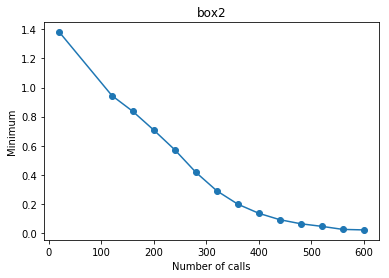

In [56]:
print(obj_lst,counter_lst)
plt.plot(counter_lst,obj_lst,'-o')
plt.xlabel("Number of calls")
plt.ylabel("Minimum")
plt.title(blackbox_name)
plt.savefig(blackbox_name+".png")

In [162]:
import matplotlib.pyplot as plt
blackbox_name = "branin"
compileCode(blackbox_name)
numOfVar,lowerBound,upperBound,startPoint = read_datafile(blackbox_name)
step = 1
obj_lst = []
counter_lst = []
counter = 0

Blackbox Model Name:  branin
Compilation finished
Number of Variables:  2
Lower Boundary:  [-5.0, 0.0]
Upper Boundary:  [10.0, 15.0]
Starting point is:  [2.5, 7.5]


In [196]:
for cycle in range(12):
    for indexOfVar in range(len(startPoint)):
        lb,ub = variable_range(lowerBound,upperBound,startPoint,indexOfVar,step)
        var_seq = van_der_corput(lb[indexOfVar],ub[indexOfVar],20)
        ydata,xdata = generate_bbox_values(blackbox_name,startPoint,var_seq,indexOfVar)
        labels,expr = call_alamopy(xdata,ydata,lowerBound,upperBound)
        optimal_point,optimal_val = call_baron(labels,expr,lb,ub,startPoint,indexOfVar)
        box_val = check_bbox_optimal(blackbox_name,optimal_point)

#             print(obj_lst)
        flag = check_objvalues(obj_lst,optimal_val)
        if(flag == 0):
            obj_lst.append(box_val)
            print("Continue update: ",optimal_val)
            counter_lst.append(counter)
            counter += 16
            pass
        elif(flag == 1):
#                 print("Stop update")
            pass
        else:
            obj_lst.append(box_val)
            print("Computation finished: ",optimal_val)
            counter_lst.append(counter)
            counter += 16
            break

        step = update_startpoint(optimal_val,box_val,optimal_point,startPoint,indexOfVar,step)
        

Continue update:  3.9062498437499734e+29
The point is updated
Optimization result:  3.906249843749975e+29
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[x1]
Continue update:  3.152516553639762e+29
The point is not updated
Optimization result:  3.906249843749975e+29
ERROR: evaluating object as numeric value: x[x1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[x1]
Continue update:  3.258154927783039e+29
The point is not updated
Optimization result:  3.906249843749975e+29
ERROR: evaluating object as numeric value: x[x2]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[x2]
Computation finished:  3.906249843749975e+29
Computation finished:  3.906249843749975e+29
ERROR: evaluating object as numeric value: x[x3]
        (object: <class 'py

[1.407048495137266, 0.926692759755859, 0.803314824453255, 0.667124989293737, 0.542656205423951, 0.389392107450458, 0.269981828913292, 0.185607293573967, 0.123863594818215, 0.085116049125236, 0.047715224657182, 0.036144418360012, 0.017961521662661, 0.007550704177877]


ValueError: x and y must have same first dimension, but have shapes (0,) and (14,)

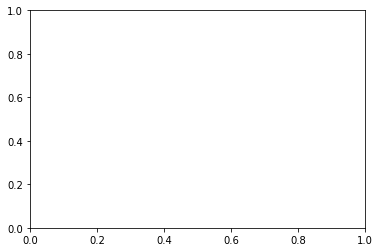

In [233]:
print(obj_lst)
plt.plot(counter_lst,obj_lst,'-o')
plt.xlabel("Number of calls")
plt.ylabel("Minimum")
plt.title(blackbox_name)
plt.savefig("branin.png")